<a href="https://colab.research.google.com/github/fatemehes75/Demand_forcasting_using_LSTM/blob/main/Demand_Forecasting_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Demand Forecasting using LSTM

In order to meet customer demand effectively, it is essential for retailers to consistently engage in dynamic planning activities. The key to this planning is the generation of **precise demand forecasts, which enable retailers to anticipate the specific inventory requirements for each store location**. These forecasts play a crucial role in maintaining sufficient product availability for customers, while simultaneously minimizing the associated stock risks.

To achieve these goals, the project will leverage Long Short-Term Memory (LSTM) technology, which is particularly well-suited for handling time-series data and is widely recognized for its effectiveness in forecasting applications.

## About Dataset

* **date** - Date of the sale data. There are no holiday effects or store closures.

* **store** - Store ID

* **item** - Item ID

* **sales** - Number of items sold at a particular store on a particular date.

Steps:

1. Importing Libraries
2. Dataset Gathering
3. Data Wrangling
4. Exploratory Data Analysis
5. Model Development
6. Model Evaluation

### 1. Importing Libraries

In [1]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dense, Dropout

### 2. Dataset Gathering

In [2]:
df = pd.read_csv('sales.csv')

### 3. Data Wrangling

In [3]:
#Data Inspection
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [4]:
print('train size',df.shape)

train size (913000, 4)


In [5]:
#handling missing values
df.dropna()  # Remove rows with missing values
df.fillna(0)  # Fill missing values with zeros
df['sales'] = df['sales'].astype(int)

In [6]:
column_traindf_types = df.dtypes
print(column_traindf_types)

date     object
store     int64
item      int64
sales     int64
dtype: object


In [7]:
df.isnull().any()

date     False
store    False
item     False
sales    False
dtype: bool

In [8]:
# Convert date columns to datetime
df['date'] = pd.to_datetime(df['date'])

### 4. Exploratory Data Analysis

In [9]:
df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


Now we want to study sales data for various  items. By examining sales performance across different items and stores, you can identify trends, patterns, or variations.

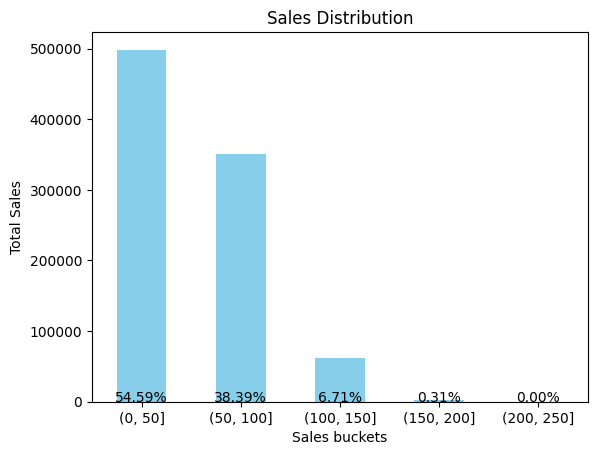

In [10]:
# Copy the DataFrame to avoid modifying the original data
sales_df = df.copy()

# Define the bins for sales
sales_bins = [0, 50, 100, 150, 200, 250]

# Create a new column with sales bins
# Categorize the values in the 'sales' column into predefined bins
# For example Values from 0 to 50 (exclusive) will be labeled as '(0, 50]' and so on
sales_df['sales_bins'] = pd.cut(sales_df['sales'], bins=sales_bins)

max_sale = sales_df['sales'].max()
min_sale = sales_df['sales'].min()
avg_sale = sales_df['sales'].mean()



# Calculate the percentage distribution of sales in different buckets
sales_bucket_distribution = pd.value_counts(sales_df['sales_bins']).sort_index()
total_points = sales_bucket_distribution.sum()
percentage_distribution = (sales_bucket_distribution / total_points) * 100


# Visualize the sales bucket distribution
ax = sales_bucket_distribution.plot(kind='bar', color='skyblue')
plt.xlabel('Sales buckets')
plt.ylabel('Total Sales')
plt.title('Sales Distribution')
plt.xticks(rotation=0)

# Add percentage labels on top of each bar
for i, v in enumerate(percentage_distribution):
    ax.text(i, v + 1, f'{v:.2f}%', color='black', ha='center')

plt.show()

In [11]:
print('Max sale:', max_sale)
print('Min sale:', min_sale)
print('Avg sale:', avg_sale)
print()

Max sale: 231
Min sale: 0
Avg sale: 52.250286966046005



As we can see, almost 92% of sales are less than 100.

Now we want to find out how does sales vary across stores

In [12]:
store_df = df.copy()

# Group the data by 'store' and calculate statistics
store_sales_stats = store_df.groupby(['store', 'item'])['sales'].mean().reset_index()

# Print the statistics
display(store_sales_stats)

,store,item,sales
0,1,1,19.971522
1,1,2,53.148959
2,1,3,33.208105
3,1,4,19.956188
4,1,5,16.612815
...,...,...,...
495,10,46,66.046550
496,10,47,24.755750
497,10,48,57.814896
498,10,49,33.032311


This dataframe has average sales per each store per each item.

<Axes: ylabel='Frequency'>

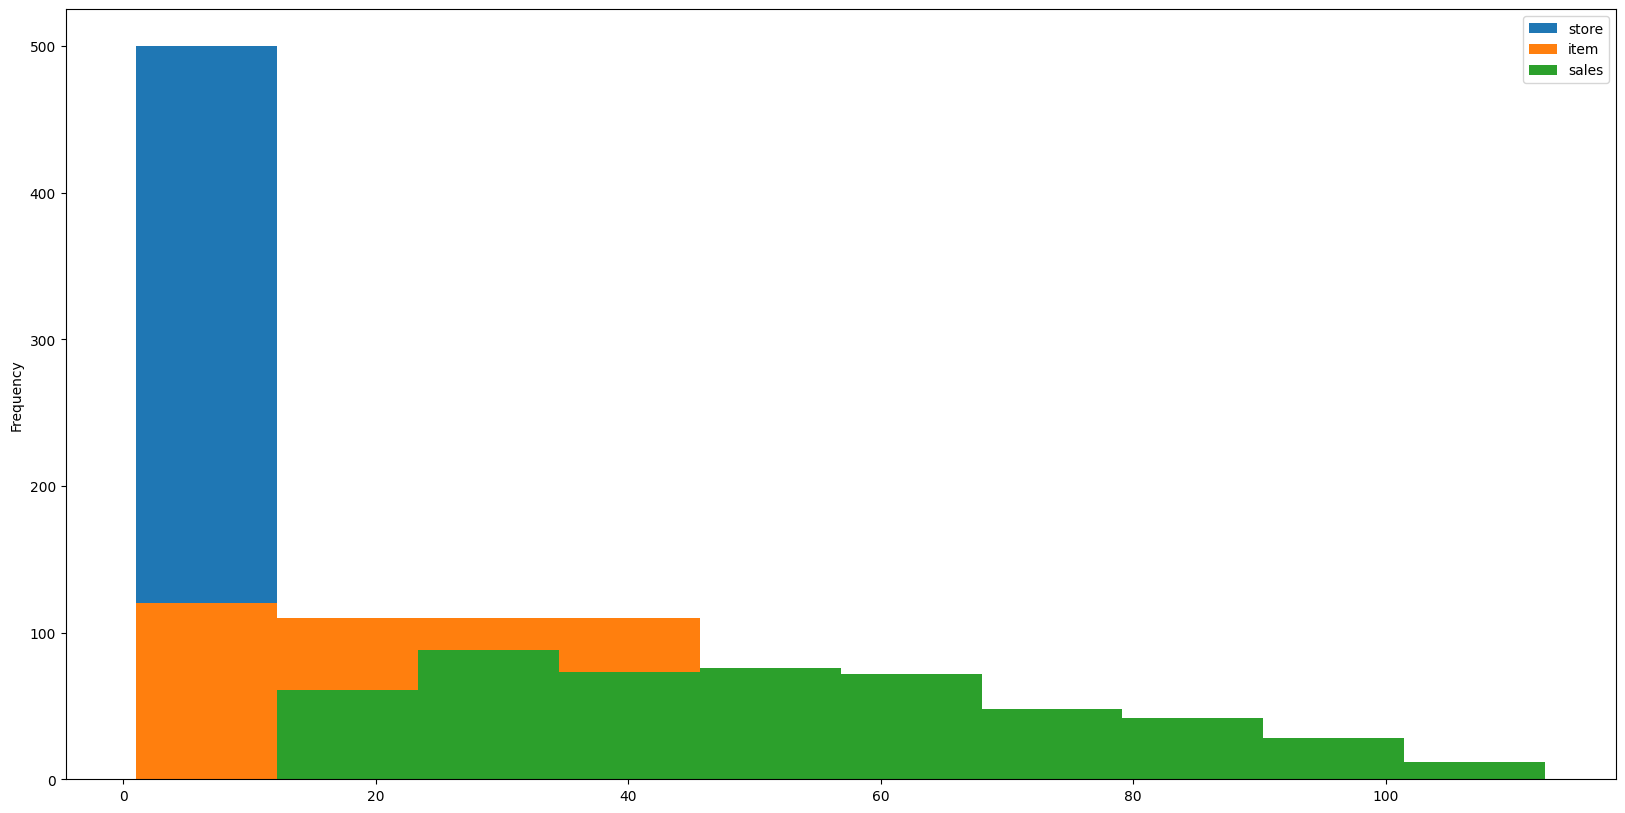

In [13]:
store_sales_stats.plot(kind="hist", figsize=(20, 10))

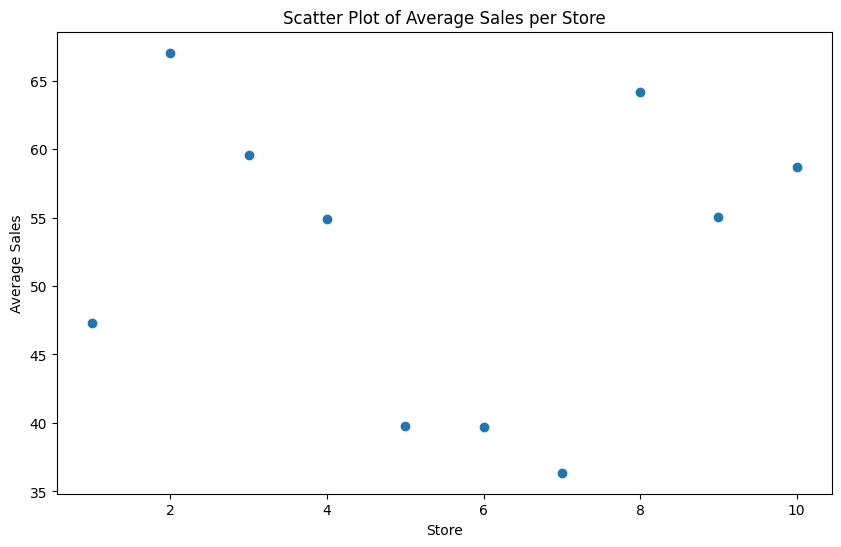

In [14]:
# Create a scatter plot of average sales per store
store_sales_stats = store_df.groupby('store')['sales'].mean().reset_index()

# Create a scatter plot of average sales per store with colors and sizes
plt.figure(figsize=(10, 6))
plt.scatter(store_sales_stats['store'], store_sales_stats['sales'])
plt.xlabel('Store')
plt.ylabel('Average Sales')
plt.title('Scatter Plot of Average Sales per Store')
plt.show()

From the visualization, it is clear that the stores with ID= 2, 8 have higher average sales than other stores.

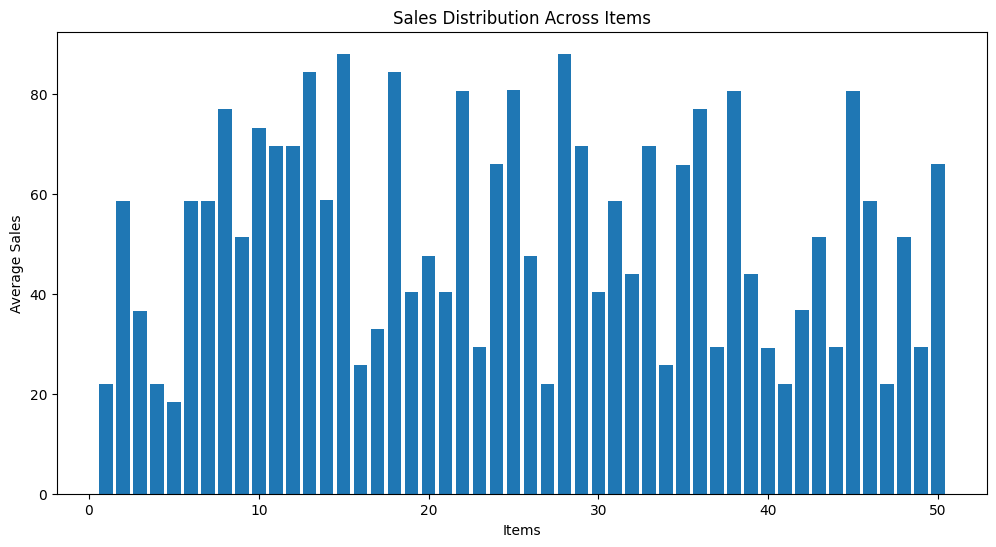

In [15]:
item_sales_df = df.copy()
item_avg_sales = df.groupby('item')['sales'].mean().reset_index()


# Create a bar plot to visualize sales across items
plt.figure(figsize=(12, 6))
plt.bar(item_avg_sales['item'], item_avg_sales['sales'])
plt.xlabel('Items')
plt.ylabel('Average Sales')
plt.title('Sales Distribution Across Items')
plt.show()

Now we want to see how sales of a given item in a given store varies in a span of 5 years.

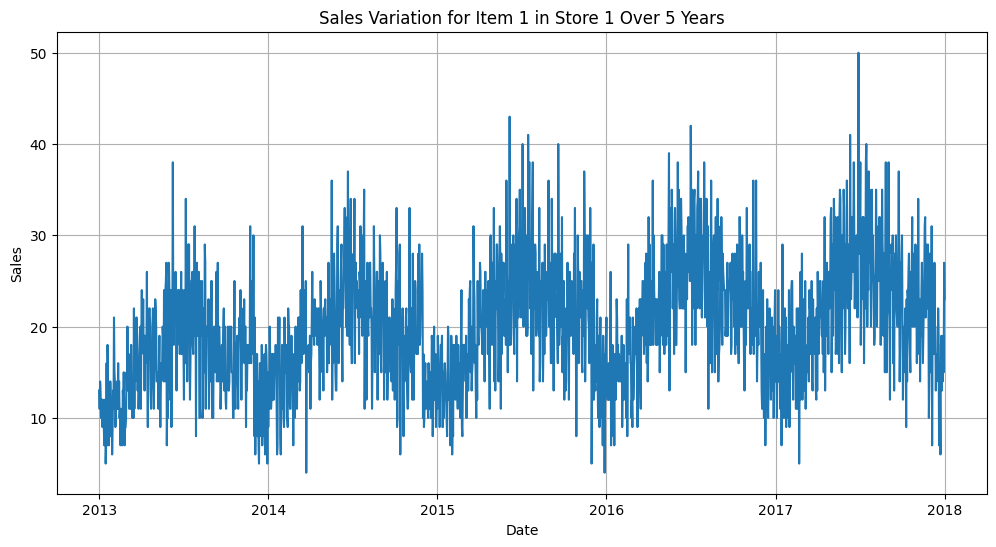

In [16]:
# Filter the data for a specific item and store
item_id = 1  # Replace with the item ID you want to analyze
store_id = 1  # Replace with the store ID you want to analyze
filtered_data = df[(df['item'] == item_id) & (df['store'] == store_id)]

# Sort the data by date
filtered_data = filtered_data.sort_values(by='date')

# Create a line plot to visualize sales variation over 5 years
plt.figure(figsize=(12, 6))
plt.plot(filtered_data['date'], filtered_data['sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title(f'Sales Variation for Item {item_id} in Store {store_id} Over 5 Years')
plt.grid(True)

From the figure it seems tha the sales go high in June, July and August. While sales will be lowest in December, January and February.

### 5. Model Development

Data preprocessing

In [17]:
from sklearn.model_selection import train_test_split

# Extract date features
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.dayofweek
df['year'] = df['date'].dt.year

df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.dayofweek
df['year'] = df['date'].dt.year

# Define columns for features and target
col = [i for i in df.columns if i not in ['date', 'id']] #col includes all columns
#in test_df except 'date' and 'id'.
#These are the input variables used to predict the target variable ('sales').
y = 'sales'

train_x, test_x, train_y, test_y = train_test_split(df[col],df[y], test_size=0.2, random_state=42)

In [18]:
train_x.shape, test_x.shape

((730400, 6), (182600, 6))

In [19]:
# reshape input to be like :[samples, time steps, features]
train_x = np.array(train_x).reshape(train_x.shape[0], 1, train_x.shape[1])
test_x = np.array(test_x).reshape(test_x.shape[0], 1, test_x.shape[1])
train_x.shape,test_x.shape

((730400, 1, 6), (182600, 1, 6))

LSTM layers are develped for our model. The LSTM model sees the input data as a sequence, so it's able to learn patterns from sequenced data (assuming it exists) better than the other ones, especially patterns from long sequences.

batch_size=32 it means it every epoch 730400/32=22825 samples are updated.

In [21]:
_optimiser = ['Adam','Nadam','RMSprop']
model = Sequential()
model.add(LSTM(144, batch_input_shape=(32, 1, 6), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=_optimiser[0]) #Adam is chosen, you can change it
model.summary()
history = model.fit(train_x,train_y, batch_size=32,epochs=5)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (32, 144)                 86976     
                                                                 
 dense_1 (Dense)             (32, 1)                   145       
                                                                 
Total params: 87121 (340.32 KB)
Trainable params: 87121 (340.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
22825/22825 [==============================] - 96s 4ms/step - loss: 743.6625
Epoch 2/5
22825/22825 [==============================] - 86s 4ms/step - loss: 287.6662
Epoch 3/5
22825/22825 [==============================] - 88s 4ms/step - loss: 92.3236
Epoch 4/5
22825/22825 [==============================] - 88s 4ms/step - loss: 31.4701
Epoch 5/5
22825/22825 [==============================] - 86s 4ms/s

### 6. Model Evaluation

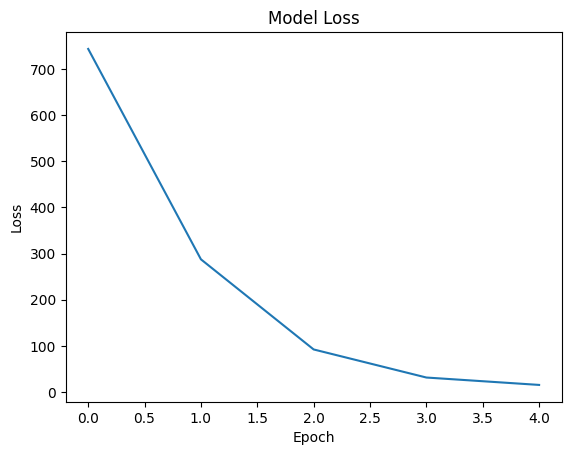

In [22]:
#Evaluation
# Plot the training loss and validation loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [23]:
test_x.shape

(182600, 1, 6)

In [32]:
test_x = test_x[:182592]

In [33]:
test_x.shape

(182592, 1, 6)

The batch size was 32 and test_x size is not a multiple of 32, I encountered shape issues. so, I truncated few samples.

In [40]:
predicted_sales =  model.predict(test_x)

5706/5706 [==============================] - 13s 2ms/step


In [42]:
predicted_sales

array([[ 21.232765],
       [ 18.48051 ],
       [101.57242 ],
       ...,
       [ 50.315605],
       [ 33.48729 ],
       [ 18.498   ]], dtype=float32)

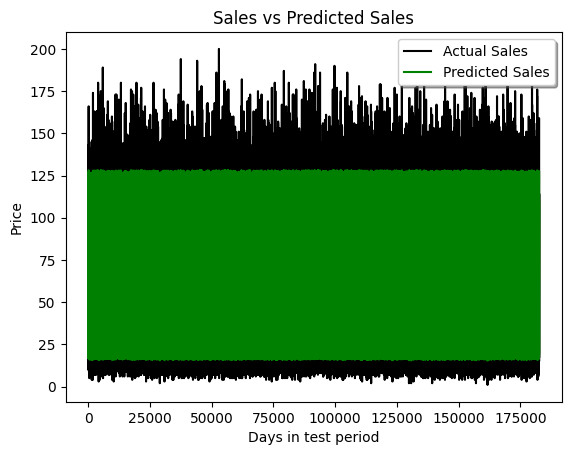

In [43]:
plt.plot(test_y, color='black', label=f"Actual Sales")
plt.plot(predicted_sales, color= 'green', label="Predicted Sales")
plt.title("Sales vs Predicted Sales")
plt.xlabel("Days in test period")
plt.ylabel("Price")
plt.legend(fancybox=True, shadow=True)
plt.show()